### Pump it Up: Setting up a business plan

**Client Situation**

Your client is the Tanzanian Ministry of Water. Providing access to clean water for the entire population is their top priority.  
The main water source for many Tanzanian citizens is a water pump. Recently our client collected data on a sample of all of their water pumps 
to get an idea of how many of them are still working.  
They concluded that some of the pumps either need to be **repaired (functional needs repair)** or **replaced (non functional)**.  
The Ministry wants to know in advance which pumps are most likely to be non-functional (**this is where the predictive part comes in**), so that they can triage their repair efforts.  
They ask help to come up with a repair and replace strategy that minimizes time/cost and optimizes water access.

### Imports

In [4]:
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import shap
from numpy import arange
from pandas import DataFrame, Series, merge, read_csv
from pandas_profiling import ProfileReport

sns.set_style("dark")

sys.path.append("../")

### Load the training set features and labels

#### Load the data

In [5]:
df_train_feat = read_csv("../data/train_features_cleaned_businessplan.csv")
df_train_feat.shape

(59400, 24)

In [6]:
df_train_labels = read_csv("../data/training_set_labels.csv")
df_train_labels.shape

(59400, 2)

##### Bind the data together

In [7]:
df_train = df_train_feat.merge(df_train_labels, on="id")

In [8]:
ProfileReport(df_train)

Summarize dataset:   0%|          | 0/39 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Get an overview of the counts per label value

In [9]:
df_train_labels["status_group"].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

### 0. Retain only the stations that need to be repaired/replaced

In [10]:
df_train_0 = df_train.loc[
    df_train["status_group"].isin(["non functional", "functional needs repair"])
]
df_train_0.shape[0]

27141

In [11]:
df_functional = df_train.loc[df_train["status_group"].isin(["functional"])]

### 1. Focus on stations with good water quality

##### If the quality of the water is not good, set it to bad

In [12]:
df_train_0.loc[df_train_0["quality_group"] != "good", "quality_group"] = "bad"


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
df_water_quality_rep = df_train_0.copy()
df_water_quality_rep = df_water_quality_rep[
    df_water_quality_rep["status_group"].isin(
        ["non functional", "functional needs repair"]
    )
]
df_water_quality_rep = (
    df_water_quality_rep.groupby(["status_group", "quality_group"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
)
df_water_quality_rep["percentage"] = df_water_quality_rep[
    "count"
] / df_water_quality_rep.groupby("status_group")["count"].transform("sum")
df_water_quality_rep

status_group quality_group  count  percentage
0  functional needs repair           bad    413    0.095668
1  functional needs repair          good   3904    0.904332
2           non functional           bad   4670    0.204609
3           non functional          good  18154    0.795391

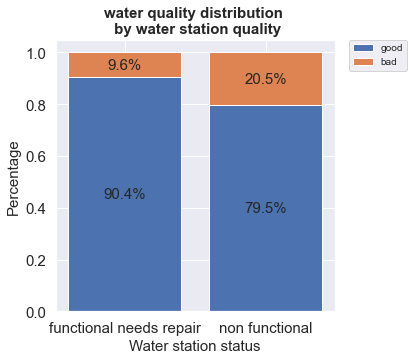

In [14]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(5, 5))

ax.bar(
    df_water_quality_rep.loc[
        df_water_quality_rep["quality_group"] == "good", "status_group"
    ],
    df_water_quality_rep.loc[
        df_water_quality_rep["quality_group"] == "good", "percentage"
    ],
    label="good",
)

ax.bar(
    df_water_quality_rep.loc[
        df_water_quality_rep["quality_group"] == "bad", "status_group"
    ],
    df_water_quality_rep.loc[
        df_water_quality_rep["quality_group"] == "bad", "percentage"
    ],
    label="bad",
    bottom=df_water_quality_rep.loc[
        df_water_quality_rep["quality_group"] == "good", "percentage"
    ],
)

ax.set_ylabel("Percentage", font="Arial", fontsize=15)
ax.set_xlabel("Water station status", font="Arial", fontsize=15)
ax.set_title(
    "water quality distribution \n by water station quality",
    font="Arial",
    fontsize=15,
    weight="bold",
)
plt.tick_params(labelsize=15)
ax.legend(fontsize=10, loc=2, borderaxespad=0.0, bbox_to_anchor=(1.05, 1))

for c in ax.containers:

    # Optional: if the segment is small or 0, customize the labels
    labels = [
        str(round(v.get_height() * 100, 1)) + "%" if v.get_height() > 0 else ""
        for v in c
    ]

    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(
        c, labels=labels, label_type="center", weight="bold", font="arial", fontsize=15
    )

plt.savefig("water_quality_by_station_quality.jpg", bbox_inches="tight")
plt.show()

##### Remove the water stations with bad quality from consideration

In [15]:
df_train_1 = df_train_0.loc[df_train["quality_group"] == "good", :]
df_train_1.shape[0]

22058

### 2. Focus on water pump type with a high percentage of functional pumps

In [133]:
# Count the number of functional/non functional/damaged waterstations per waterpoint_type
# Count the number of functional/non functional/damaged waterstations per waterpoint_type
df_pump_type = df_train.copy()
df_pump_type.loc[df_pump_type["status_group"] == "functional","status_group_2"] = "functional"
df_pump_type.loc[df_pump_type["status_group"] != "functional","status_group_2"] = "non_functional"

df_pump_type = (
    df_pump_type.groupby(["status_group_2", "waterpoint_type"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
).set_index(["status_group_2","waterpoint_type"])

In [134]:
# df_pump_type

In [135]:
# Sort the dataframe properly for later visualization with stacked bar charts
s_sort = df_pump_type.groupby(level=[1]).sum().sort_values(by="count", ascending=False)

In [136]:
df_pump_type = df_pump_type.reindex(index=s_sort.index, level=1).reset_index()

In [137]:
df_train["status_group"].value_counts()
print(
    f"The percentage of functional waterstations in the training set is {round((32259/59400)*100,2)}%."
)

The percentage of functional waterstations in the training set is 54.31%.


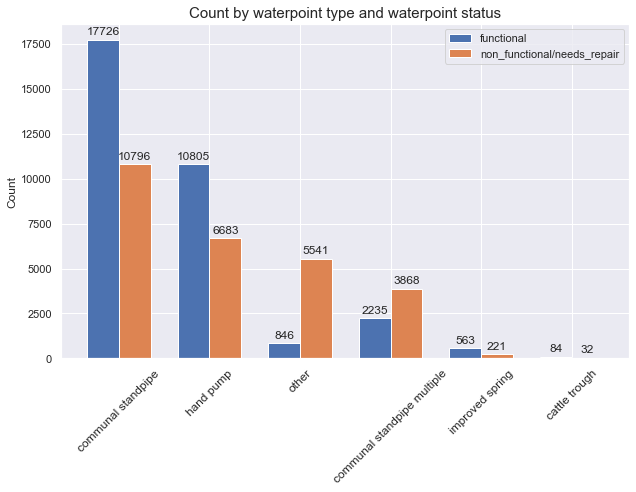

In [139]:
fig, ax = plt.subplots(figsize=(9, 7))
width = 0.35

# create the labels and the series values
labels = list(df_pump_type["waterpoint_type"].unique())
x = arange(len(labels))

functional = df_pump_type[df_pump_type["status_group_2"] == "functional"]["count"]
non_functional = df_pump_type[df_pump_type["status_group_2"] == "non_functional"]["count"]


rects1 = ax.bar(x - width / 2, functional, width, label="functional")
rects2 = ax.bar(
    x + width / 2, non_functional, width, label="non_functional/needs_repair"
)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Count by waterpoint type and waterpoint status", fontsize=15)
ax.legend()
plt.xticks(ticks=x, labels=labels, rotation=45, fontsize=12)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
fig.savefig("waterpoint_types.jpg")
plt.show()

**The figure above shows that categories "other", "communal standpipe multiple" and "cattle trough" have a very high degree of non_functional/damaged waterpoints. Hence, it is adviced to focus on the other types**df_train_2

In [143]:
# df_train_1["waterpoint_type"].value_counts()

In [140]:
df_train_2 = df_train_1.loc[
    df_train_1["waterpoint_type"].isin(
        ["communal standpipe", "hand pump", "improved spring","cattle_trough"]
    )
]

In [141]:
df_train_2.shape[0]

15036

### 3. Focus on stations with ample water availability

In [115]:
# Count the number of functional/non functional/damaged waterstations per waterpoint_type
df_quantity = df_train.copy()
df_quantity.loc[df_quantity["status_group"] == "functional","status_group_2"] = "functional"
df_quantity.loc[df_quantity["status_group"] != "functional","status_group_2"] = "non_functional"

df_quantity = (
    df_quantity.groupby(["status_group_2", "quantity"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
).set_index(["status_group_2","quantity"])

In [117]:
# Sort the dataframe properly for later visualization with stacked bar charts
quantity_sort = (
    df_quantity.groupby(level=[1]).sum().sort_values(by="count", ascending=False)
)

In [118]:
df_quantity = df_quantity.reindex(index=quantity_sort.index, level=1).reset_index()

In [119]:
df_quantity["quantity"].unique()

array(['enough', 'insufficient', 'dry', 'seasonal', 'unknown'],
      dtype=object)

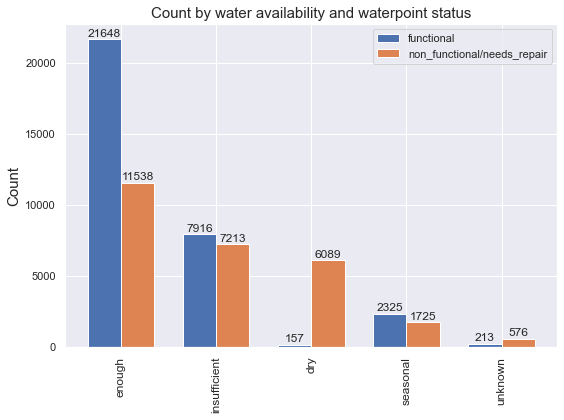

In [121]:
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.35

# create the labels and the series values
labels = list(df_quantity["quantity"].unique())
x = arange(len(labels))

functional = df_quantity[df_quantity["status_group_2"] == "functional"]["count"]
non_functional = df_quantity[df_quantity["status_group_2"] == "non_functional"]["count"]

rects1 = ax.bar(x - width / 2, functional, width, label="functional")
rects2 = ax.bar(
    x + width / 2, non_functional, width, label="non_functional/needs_repair"
)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Water availability", fontsize=15)
ax.set_ylabel("Count", fontsize=15)
ax.set_title("Count by water availability and waterpoint status", fontsize=15)
ax.legend()
plt.xticks(ticks=x, labels=labels, rotation="vertical", fontsize=12)

ax.bar_label(rects1, padding=1)
ax.bar_label(rects2, padding=1)

fig.tight_layout()
fig.savefig("quantities.jpg")
plt.show()

In [148]:
# Count the number of functional/non functional/damaged waterstations per waterpoint_type
df_quantity_2 = df_train_2.copy()
df_quantity_2 = (
    df_quantity_2.groupby([ "quantity"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
).sort_values(by = "count", ascending = False)

In [149]:
df_quantity_2

quantity  count
1        enough   6767
2  insufficient   4085
0           dry   3062
3      seasonal   1062
4       unknown     60

No handles with labels found to put in legend.


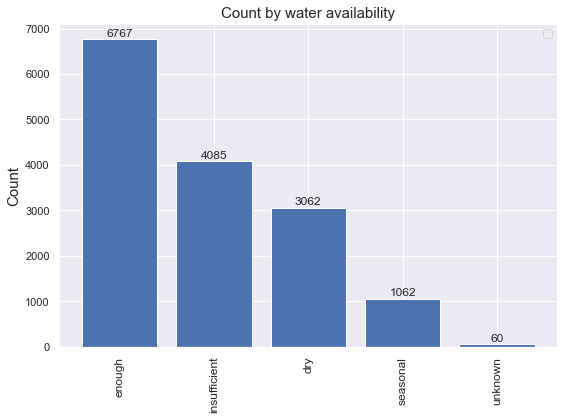

In [157]:
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.35

# create the labels and the series values
labels = list(df_quantity["quantity"].unique())
x = arange(len(labels))

functional = df_quantity[df_quantity["status_group_2"] == "functional"]["count"]
# non_functional = df_quantity[df_quantity["status_group_2"] == "non_functional"]["count"]

rects1  = ax.bar(
    df_quantity_2["quantity"],
    df_quantity_2["count"]
)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Water availability", fontsize=15)
ax.set_ylabel("Count", fontsize=15)
ax.set_title("Count by water availability", fontsize=15)
ax.legend()
plt.xticks(ticks=x, labels=labels, rotation="vertical", fontsize=12)

# rects1 = ax.bar(x - width / 2, df_quantity_2["count"], width, label="functional")
ax.bar_label(rects1, padding=1)


fig.tight_layout()
fig.savefig("quantities_2.jpg")
plt.show()

In [123]:
df_train_3 = df_train_2[df_train_2["quantity"] == "enough"]

In [124]:
df_train_3.shape[0]

6767

### 2. Focus on stations with a high population around it
It is more efficient to focus on wells with a high population around them.  

In [34]:
df_train_3.sort_values(by=["region", "population"], ascending=False, inplace=True)
df_train_3["population_cumsum_region"] = df_train_1.groupby("region")[
    "population"
].transform(Series.cumsum)
df_train_3.sort_values(by=["population"], ascending=False, inplace=True)
df_train_3["population_cumsum"] = df_train_3["population"].transform(Series.cumsum)
df_train_3["population_perc"] = (
    df_train_3["population_cumsum"] / df_train_3["population"].sum()
)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [35]:
df_train_3[
    [
        "region",
        "population",
        "population_cumsum",
        "population_cumsum_region",
        "population_perc",
    ]
]

region  population  population_cumsum  population_cumsum_region  \
12784  Dar es Salaam      9865.0       9.865000e+03              26857.294737   
10940         Kigoma      5200.0       1.506500e+04             121291.610358   
41073          Pwani      5000.0       2.006500e+04             255504.828157   
45405         Kigoma      4500.0       2.456500e+04             550135.907152   
45414           Mara      4500.0       2.906500e+04             294147.199811   
...              ...         ...                ...                       ...   
46082       Morogoro         6.0       2.410974e+06             296065.316512   
14829         Iringa         5.0       2.410979e+06              54050.148415   
33092    Kilimanjaro         5.0       2.410984e+06             176297.009829   
23720          Tanga         5.0       2.410989e+06             103967.394668   
58063    Kilimanjaro         5.0       2.410994e+06             312128.474155   

       population_perc  
12784         0.004092  
10940         0.006248  
41073         0.008322  
45405         0.010189  
45414         0.012055  
...                ...  
46082         0.999992  
14829         0.999994  
33092         0.999996  
23720         0.999998  
58063         1.000000  

[6767 rows x 5 columns]

In [38]:
xticks = [i / df_train_3.shape[0] for i in range(0, df_train_3.shape[0])]

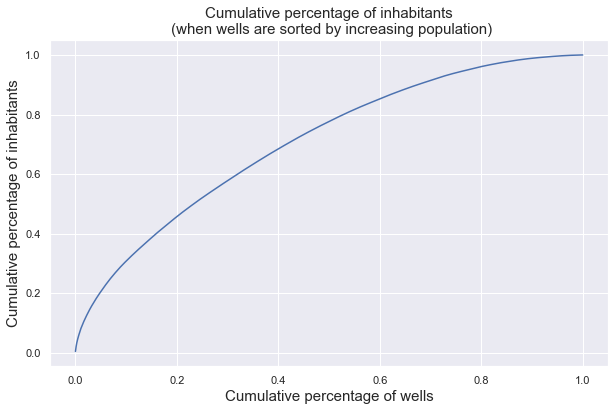

In [55]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df_train_3, x=xticks, y="population_perc")

# Clean up the figure
ax.grid(True)
ax.set_title(
    "Cumulative percentage of inhabitants\n (when wells are sorted by increasing population)",
    fontsize=15,
)
ax.set_xlabel("Cumulative percentage of wells", fontsize=15)
ax.set_ylabel("Cumulative percentage of inhabitants", fontsize=15)

fig.savefig("population_cum.jpg")
plt.show()

In [47]:
df_train.loc[df_train["status_group"] == "functional", "population"].sum()

11757388.076324977

In [42]:
df_train_3["population"].sum()

2410994.2917891466

In [41]:
for i in range(1, 10):
    print(f"quantile {i/10}: {int(df_train_3['population_cumsum'].quantile(i/10))}")

quantile 0.1: 741808
quantile 0.2: 1102295
quantile 0.3: 1393367
quantile 0.4: 1650802
quantile 0.5: 1872264
quantile 0.6: 2055713
quantile 0.7: 2204855
quantile 0.8: 2316900
quantile 0.9: 2384376


In [56]:
df_train_4 = df_train_3.loc[
    df_train_3["population_cumsum"] > 0.8 * df_train_3["population"].sum()
]

In [57]:
df_train_4.shape[0]

3192

In [74]:
df_wells_remaining_by_region_before = DataFrame(
    df_train_1["region"].value_counts()
).rename(columns={"region": "initial_nr_stations"})

In [75]:
df_wells_remaining_by_region_after = DataFrame(
    df_train_4["region"].value_counts()
).rename(columns={"region": "final_nr_stations"})

In [80]:
df_train_4["status_group"].value_counts()

non functional             2434
functional needs repair     758
Name: status_group, dtype: int64

In [78]:
df_wells = df_wells_remaining_by_region_before.merge(
    df_wells_remaining_by_region_after, left_index=True, right_index=True
)
df_wells["percentage_lost"] = (
    df_wells["initial_nr_stations"] - df_wells["final_nr_stations"]
) / df_wells["initial_nr_stations"]

In [79]:
df_wells

initial_nr_stations  final_nr_stations  percentage_lost
Mbeya                         2154                267         0.876045
Kilimanjaro                   1695                410         0.758112
Shinyanga                     1626                 93         0.942804
Kagera                        1457                 71         0.951270
Kigoma                        1412                121         0.914306
Morogoro                      1357                360         0.734709
Mwanza                        1200                 33         0.972500
Ruvuma                        1132                 83         0.926678
Iringa                        1106                399         0.639241
Arusha                        1000                 98         0.902000
Dodoma                         964                 98         0.898340
Rukwa                          930                319         0.656989
Mtwara                         927                 65         0.929881
Pwani                          905                233         0.742541
Tabora                         895                 49         0.945251
Mara                           796                124         0.844221
Tanga                          771                123         0.840467
Singida                        555                 47         0.915315
Lindi                          545                 46         0.915596
Manyara                        442                109         0.753394
Dar es Salaam                  189                 44         0.767196